## Read In Raw Data

In [1]:
# Load the updated CSV file to get the data
file_path_updated = '12-04-10-55/12-04-10-55-study4_data.csv' #'11-27-09-study4_data.csv'    # The very original dataset: 11-26-16-study4_data.csv

# Get the row index
row_index = 1100

# Get the temporal prefix
last_hyphen_index = file_path_updated.rfind('-')
prefix = file_path_updated[:last_hyphen_index]

if '/' in prefix:
    prefix = prefix.split('/')[0]

## Extract Data for Plots

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from ast import literal_eval

# Load the updated CSV file to get the data
data_updated = pd.read_csv(file_path_updated)

# Function to convert string representations of lists into actual lists
def literal_eval_col(col):
    return col.apply(literal_eval)

def round_nested_lists(column):
    rounded_column = []
    for row in column:
        if isinstance(row, list):
            rounded_row = [round(element, 1) if isinstance(element, float) else element for element in row]
            rounded_column.append(rounded_row)
        else:
            rounded_column.append(row)
    return rounded_column

# Apply the literal_eval function to the columns that contain string representations of lists
data_updated['steps'] = literal_eval_col(data_updated['steps'])
data_updated['step_wise_walking_positions'] = literal_eval_col(data_updated['step_wise_walking_positions'])
data_updated['step_wise_walking_speeds'] = literal_eval_col(data_updated['step_wise_walking_speeds'])
data_updated['step_wise_attentions'] = literal_eval_col(data_updated['step_wise_attentions'])
data_updated['sign_positions'] = literal_eval_col(data_updated['sign_positions'])
data_updated['step_wise_reading_ratios'] = literal_eval_col(data_updated['step_wise_reading_ratios'])
# data_updated['rectangle_path_length'] = literal_eval_col(data_updated['rectangle_path_length'])
# data_updated['ep_len'] = literal_eval_col(data_updated['ep_len'])

# Round the walking and reading speed ratios
data_updated['step_wise_reading_ratios'] = round_nested_lists(data_updated['step_wise_reading_ratios'])
data_updated['step_wise_walking_speeds'] = round_nested_lists(data_updated['step_wise_walking_speeds'])

# # Extract the walking positions and attentions for each step
# walking_positions = np.concatenate(data_updated['step_wise_walking_positions'].tolist())
# attentions = np.concatenate(data_updated['step_wise_attentions'].tolist())

# Assume we are using the certain row
walking_positions = data_updated.at[row_index, 'step_wise_walking_positions']
attentions = data_updated.at[row_index, 'step_wise_attentions']
sign_positions = data_updated.at[row_index, 'sign_positions']
reading_ratios = data_updated.at[row_index, 'step_wise_reading_ratios']
walking_speeds = data_updated.at[row_index, 'step_wise_walking_speeds']
weight = data_updated.at[row_index, 'weights']
walk_factor = data_updated.at[row_index, 'walk_factor']
preferred_walking_speed = data_updated.at[row_index, 'preferred_walking_speed']
rectangle_path_length = data_updated.at[row_index, 'rectangle_path_length']
ep_len = data_updated.at[row_index, 'ep_len']

# Get the prefix of the figure name
weight_str = str(round(weight, 4))
decimal_index = weight_str.find('.')
weight_str_after_decimal = weight_str[decimal_index + 1:]

walk_factor_str = str(round(walk_factor, 4))
decimal_index_walk_factor = walk_factor_str.find('.')
walk_factor_str_after_decimal = walk_factor_str[decimal_index_walk_factor + 1:]

# Define dimensions for the visualization
long_side = 8
short_side = 7
perimeter = 2 * (long_side + short_side)

# Final check before plotting
assert perimeter == rectangle_path_length / 2

## Get Data within the Perimeter Range (60 meters)

In [3]:
# Find the index where the agent walks to two rounds (60 meters)
big_index = 0
for index, value in enumerate(walking_positions):
        if value <= rectangle_path_length:
            if index > big_index:
                big_index = index

# Refresh all list values to be under this index.
two_rounds_attentions = attentions[0:big_index+1]
two_rounds_reading_ratios = reading_ratios[0:big_index+1]
two_rounds_walking_speeds = walking_speeds[0:big_index+1]

# Check
print(len(two_rounds_attentions), len(two_rounds_reading_ratios), len(two_rounds_walking_speeds))
print(sign_positions)
print(f'weight: {weight}')
print(f'walk factor: {walk_factor}')

110 110 110
[4, 11.5, 19, 26.5, 34, 41.5, 49, 56.5]
weight: 1.0
walk factor: 0.0


## Plot: Attention Allocation 

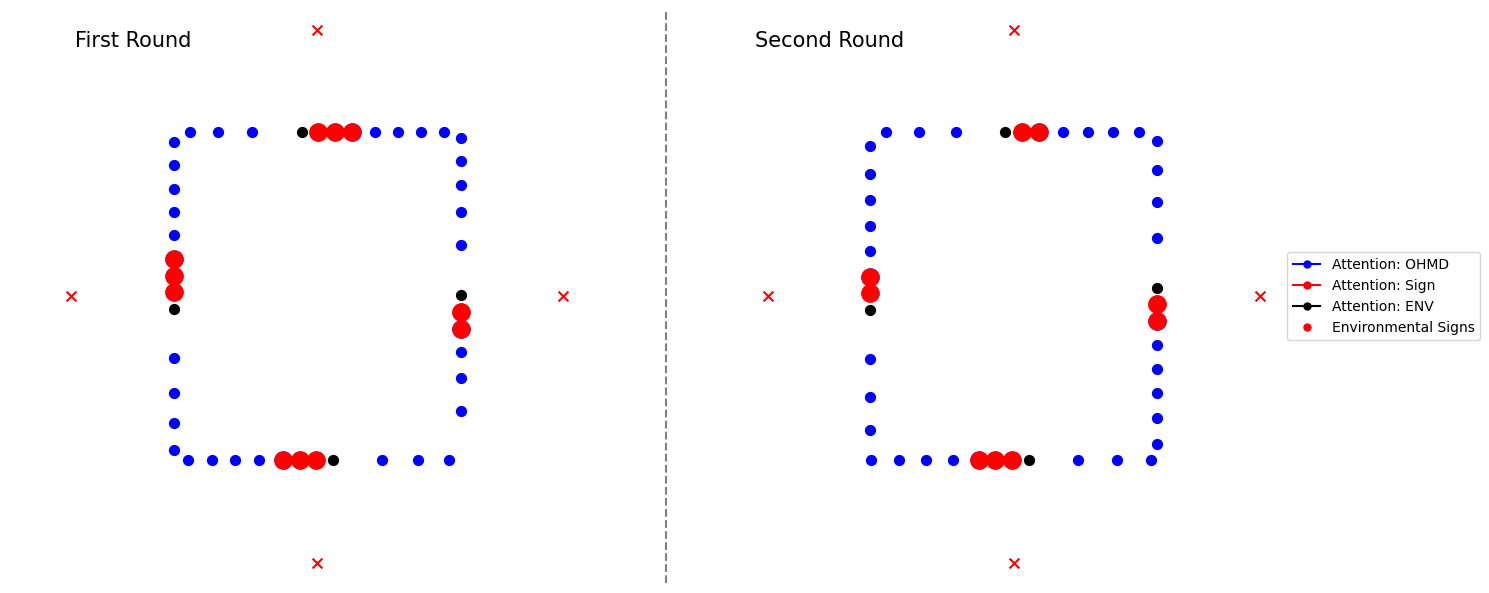

In [4]:
# Map the attentions to indices and colors
attention_unique_str = ['OHMD', 'Sign', 'ENV']
attention_to_index = {
    attention_unique_str[0]: 0,
    attention_unique_str[1]: 1, 
    attention_unique_str[2]: 2,
}

attention_to_color = {
    attention_unique_str[0]: 'blue',
    attention_unique_str[1]: 'red', 
    attention_unique_str[2]: 'black',
}

# attention_to_index = {att: idx for idx, att in enumerate(set(two_rounds_attentions))}
# attention_indices = [attention_to_index[att] for att in two_rounds_attentions]
# unique_attention_indices = sorted(set(attention_indices))
# colors = plt.cm.get_cmap('tab20', len(unique_attention_indices))
# attention_colors = {index: colors(i) for i, index in enumerate(unique_attention_indices)}
# # attention_colors = {index: colors(i) for i, index in enumerate(sorted(set(attentions)))}

# Invert the attention_to_index dictionary to map indices back to original attentions - THE PLACE WHERE I GET ORIGINAL LABELS
index_to_attention = {idx: att for att, idx in attention_to_index.items()}
###################################################################################

# Create the figure and axes with more space between the rectangles
fig, ax = plt.subplots(figsize=(15, 7))

# Function to add a small random offset to each point to prevent them from appearing too close
def jitter(value, amount=0.01):
    return value + random.uniform(-amount, amount)

# Function to calculate Euclidean distance between two points
def calculate_distance(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

# Linear scale function to determine the size multiplier
def size_scale(distance, close_dist_thres):
    if distance <= 0:
        return 3  # If points overlap, use the maximum size multiplier
    elif distance >= close_dist_thres:
        return 1  # No increase if beyond the threshold
    else:
        # Linear interpolation between 1.5 and 3 based on the distance
        return 1 + (3 - 1) * ((close_dist_thres - distance) / close_dist_thres)

# Function to calculate the position along the perimeter of the rectangle
def calculate_rectangle_position(pos, short_side, long_side, sign_offset=0):
    # Start from the right-bottom corner, so the sides are: 8, 7, 8, 7
    if pos <= long_side:  # Right side
        return short_side+sign_offset, pos
    elif long_side < pos <= (long_side + short_side): # Top side
        return short_side - (pos - long_side), long_side+sign_offset
    elif (long_side + short_side) < pos <= (long_side + short_side + long_side): # Left side
        return 0-sign_offset, long_side - (pos - (long_side + short_side))
    else: # Bottom side
        return (pos - (long_side + short_side + long_side)), 0-sign_offset

# Modified function to plot attentions based on walking positions on the rectangles
def plot_attentions_on_rectangle(ax, walking_positions, attentions, perimeter, 
                                 short_side, long_side, left_offset_x, right_offset_x, 
                                 close_dist_thres=0.01, base_size=50):
        
    # First, calculate the positions and store them with their respective attentions
    positions_with_attentions = [(calculate_rectangle_position(pos % perimeter, short_side, long_side), att_name) for pos, att_name in zip(walking_positions, attentions)]
    
    # Now, adjust the x position based on whether the position is in the first or second round
    for i, ((pos_x, pos_y), att_name) in enumerate(positions_with_attentions):
        if walking_positions[i] < perimeter:
            pos_x += left_offset_x
        else:
            pos_x += right_offset_x
        positions_with_attentions[i] = ((pos_x, pos_y), att_name)
    
    # Determine the size of each point based on the distance to other points
    point_sizes = [base_size for _ in walking_positions]
    for (i, ((pos_x1, pos_y1), _)), (j, ((pos_x2, pos_y2), _)) in itertools.combinations(enumerate(positions_with_attentions), 2):
        distance = calculate_distance((pos_x1, pos_y1), (pos_x2, pos_y2))
        scale_factor = size_scale(distance, close_dist_thres)
        point_sizes[i] = max(point_sizes[i], base_size * scale_factor)
        point_sizes[j] = max(point_sizes[j], base_size * scale_factor)

    # Draw the attention scatter points with the determined sizes
    for ((pos_x, pos_y), att_name), size in zip(positions_with_attentions, point_sizes):
        color = attention_to_color[att_name]
        ax.scatter(pos_x, pos_y, color=color, s=size)
#         ax.scatter(pos_x, pos_y, color=color, s=size, alpha=0.2)

def plot_sign_positions(sign_positions, sign_offset, left_offset_x, right_offset_x):
    # Draw sign positions
    for sign_pos in sign_positions:
        # Determine the position on the rectangle
        pos_x, pos_y = calculate_rectangle_position(sign_pos % perimeter, short_side, long_side, sign_offset)   # There are some issues
        
        # Adjust x position based on whether the position is in the first or second round
        if sign_pos < perimeter:  # First round, left rectangle
            pos_x += left_offset_x
        else:  # Second round, right rectangle
            pos_x += right_offset_x
        
        color = 'red'
        # Draw a dot for the sign positions
        ax.scatter(pos_x, pos_y, color=color, s=50, marker='x')  # s is the size of the dot

# Calculate the offsets for the left and right rectangles
left_rect_offset = 3
rectangle_offset = 10
right_rect_offset = left_rect_offset + short_side + rectangle_offset  # 5 units of space between rectangles
sign_offset = 2.5

# Plot attentions on the left and right rectangles based on walking position
plot_attentions_on_rectangle(ax, walking_positions, two_rounds_attentions, perimeter, short_side, long_side, left_rect_offset, right_rect_offset)

# Plot sign positions
plot_sign_positions(sign_positions=sign_positions, sign_offset=sign_offset, left_offset_x=left_rect_offset, right_offset_x=right_rect_offset)

# Calculate the position where the vertical separation line should be drawn
separation_line_x = left_rect_offset + short_side + rectangle_offset / 2

# Draw a vertical line to separate the two rectangles
ax.axvline(x=separation_line_x, color='grey', linestyle='--')

# Annotations for 'first round' and 'second round'
ax.text(left_rect_offset-1, long_side + 2, 'First Round', ha='center', va='bottom', fontsize=15)
ax.text(right_rect_offset-1, long_side + 2, 'Second Round', ha='center', va='bottom', fontsize=15)

# Set the plot limits
ax.set_xlim(-1, right_rect_offset + short_side + sign_offset + 0.5)  # Adjust for spacing between rectangles and borders
ax.set_ylim(-3, long_side + 3)

# Keep the aspect ratio square
ax.set_aspect('equal')

# Remove axis labels and ticks
ax.axis('off')

attention_legend_handles = [
    plt.Line2D([0], [0], marker='o', color=color, label=f'Attention: {att_name}', markersize=5)
    for att_name, color in attention_to_color.items()
]

# Add a legend handle for 'environmental signs'
environmental_signs_handle = plt.Line2D([0], [0], marker='o', color='red', linestyle='None', label='Environmental Signs', markersize=5)
attention_legend_handles.append(environmental_signs_handle)

ax.legend(handles=attention_legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

# Save the figure
save_fig_path = f"{prefix}/weight_{str(weight).replace('.', '_')}_walk_factor_{str(walk_factor).replace('.', '_')}_attention_allocation.png"
# save_fig_path = f'{prefix}/0dot{weight_str_after_decimal}-step_by_step_attention_allocation.png'
fig.savefig(save_fig_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

## Plot: Reading Speed Ratio

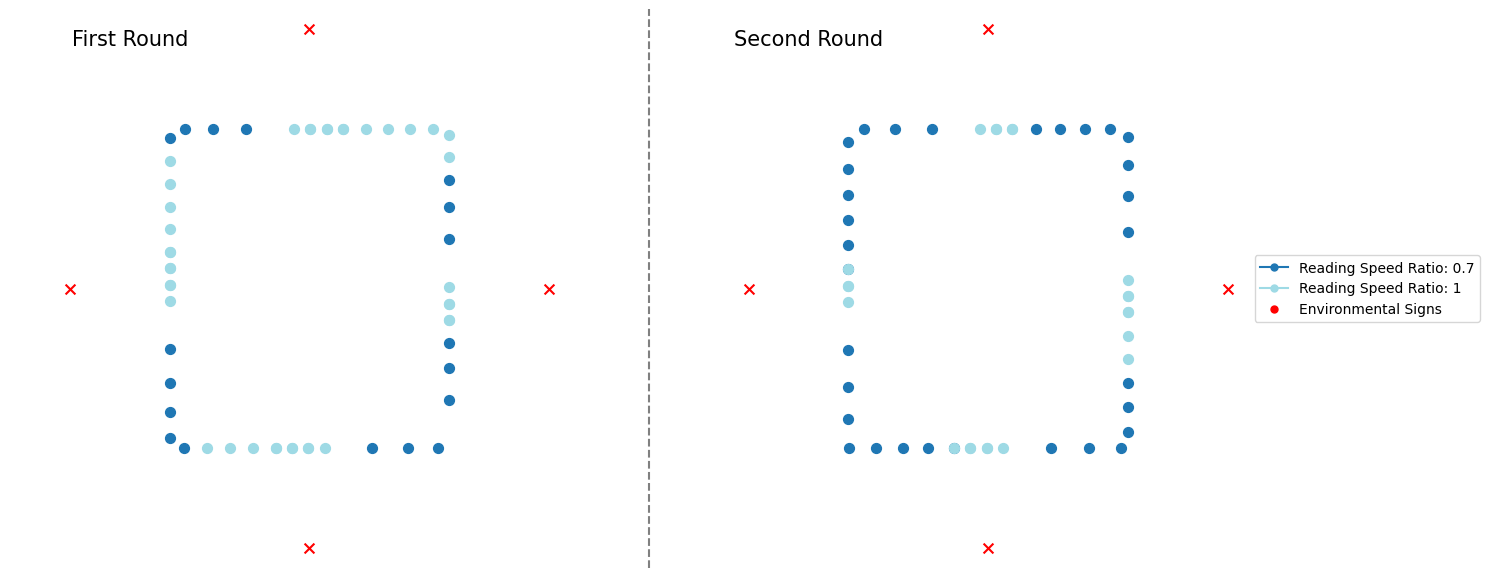

In [5]:
# Map the reading ratios to indices and colors
reading_ratios_to_index = {att: idx for idx, att in enumerate(set(two_rounds_reading_ratios))}
reading_ratios_indices = [reading_ratios_to_index[att] for att in two_rounds_reading_ratios]
unique_reading_ratios_indices = sorted(set(reading_ratios_indices))
colors = plt.cm.get_cmap('tab20', len(unique_reading_ratios_indices))
reading_ratios_colors = {index: colors(i) for i, index in enumerate(unique_reading_ratios_indices)}
# reading_ratios_colors = {index: colors(i) for i, index in enumerate(set(reading_ratios))}

###################################################################################
# Invert the attention_to_index dictionary to map indices back to original attentions - THE PLACE WHERE I GET ORIGINAL LABELS
index_to_reading_ratios = {idx: rr for rr, idx in reading_ratios_to_index.items()}
# index_to_reading_ratios[0] = 'Walking Slowly (0.9 if)'
# print(index_to_reading_ratios)
###################################################################################

# Create the figure and axes with more space between the rectangles
fig, ax = plt.subplots(figsize=(15, 7))

# Modified function to plot attentions based on walking positions on the rectangles
def plot_reading_ratios_on_rectangle(ax, walking_positions, reading_ratios, perimeter, short_side, long_side, left_offset_x, right_offset_x):

    # Draw the reading speed ratios scatter points
    for pos, reading_ratio_index in zip(walking_positions, reading_ratios):
        # Determine the position on the rectangle
        pos_x, pos_y = calculate_rectangle_position(pos % perimeter, short_side, long_side)
        
        # Adjust x position based on whether the position is in the first or second round
        if pos < perimeter:  # First round, left rectangle
            pos_x += left_offset_x
        else:  # Second round, right rectangle
            pos_x += right_offset_x
        
        color = reading_ratios_colors[reading_ratio_index]
        # Draw a dot for the attention allocation
        ax.scatter(pos_x, pos_y, color=color, s=50)  # s is the size of the dot


# Plot attentions on the left and right rectangles based on walking position
plot_reading_ratios_on_rectangle(ax, walking_positions, reading_ratios_indices, perimeter, short_side, long_side, left_rect_offset, right_rect_offset)

# Plot sign positions
plot_sign_positions(sign_positions=sign_positions, sign_offset=sign_offset, left_offset_x=left_rect_offset, right_offset_x=right_rect_offset)

# Calculate the position where the vertical separation line should be drawn
separation_line_x = left_rect_offset + short_side + rectangle_offset / 2

# Draw a vertical line to separate the two rectangles
ax.axvline(x=separation_line_x, color='grey', linestyle='--')

# Annotations for 'first round' and 'second round'
ax.text(left_rect_offset-1, long_side + 2, 'First Round', ha='center', va='bottom', fontsize=15)
ax.text(right_rect_offset-1, long_side + 2, 'Second Round', ha='center', va='bottom', fontsize=15)

# Set the plot limits
ax.set_xlim(-1, right_rect_offset + short_side + sign_offset + 0.5)  # Adjust for spacing between rectangles and borders
ax.set_ylim(-3, long_side + 3)

# Keep the aspect ratio square
ax.set_aspect('equal')

# Remove axis labels and ticks
ax.axis('off')

###################################################################################
reading_speed_ratio_legend_handles = [
    plt.Line2D([0], [0], marker='o', color=color, label=f'Reading Speed Ratio: {index_to_reading_ratios[idx]}', markersize=5)
    for idx, color in reading_ratios_colors.items()
]

# Add a legend handle for 'environmental signs'
environmental_signs_handle = plt.Line2D([0], [0], marker='o', color='red', linestyle='None', label='Environmental Signs', markersize=5)
reading_speed_ratio_legend_handles.append(environmental_signs_handle)

ax.legend(handles=reading_speed_ratio_legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
###################################################################################

# Save the figure
fig.savefig(f"{prefix}/weight_{str(weight).replace('.', '_')}_walk_factor_{str(walk_factor).replace('.', '_')}_reading_speed_ratio.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

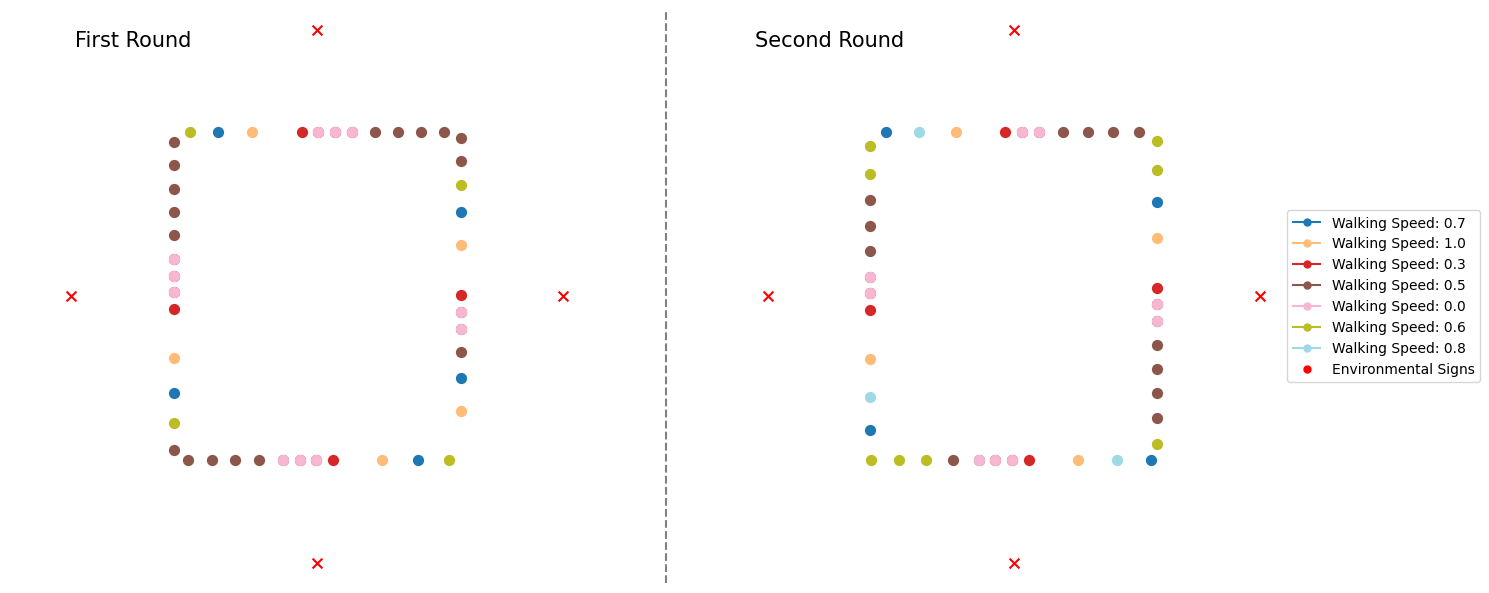

In [6]:
# Map the walking speeds to indices and colors
walking_speeds_to_index = {att: idx for idx, att in enumerate(set(two_rounds_walking_speeds))}
walking_speeds_indices = [walking_speeds_to_index[att] for att in two_rounds_walking_speeds]
unique_walking_speeds_indices = sorted(set(walking_speeds_indices))
colors = plt.cm.get_cmap('tab20', len(unique_walking_speeds_indices))
walking_speeds_colors = {index: colors(i) for i, index in enumerate(unique_walking_speeds_indices)}
# reading_ratios_colors = {index: colors(i) for i, index in enumerate(set(reading_ratios))}

# Invert the attention_to_index dictionary to map indices back to original attentions - THE PLACE WHERE I GET ORIGINAL LABELS
index_to_walking_speeds = {idx: rr for rr, idx in walking_speeds_to_index.items()}

# Create the figure and axes with more space between the rectangles
fig, ax = plt.subplots(figsize=(15, 7))

# Modified function to plot attentions based on walking positions on the rectangles
def plot_walking_speeds_on_rectangle(ax, walking_positions, walking_speeds, perimeter, short_side, long_side, left_offset_x, right_offset_x):

    # Draw the reading speed ratios scatter points
    for pos, walking_speed_index in zip(walking_positions, walking_speeds):
        # Determine the position on the rectangle
        pos_x, pos_y = calculate_rectangle_position(pos % perimeter, short_side, long_side)
        
        # Adjust x position based on whether the position is in the first or second round
        if pos < perimeter:  # First round, left rectangle
            pos_x += left_offset_x
        else:  # Second round, right rectangle
            pos_x += right_offset_x
        
        color = walking_speeds_colors[walking_speed_index]
        # Draw a dot for the attention allocation
        ax.scatter(pos_x, pos_y, color=color, s=50)  # s is the size of the dot


# Plot attentions on the left and right rectangles based on walking position
plot_walking_speeds_on_rectangle(ax, walking_positions, walking_speeds_indices, perimeter, short_side, long_side, left_rect_offset, right_rect_offset)

# Plot sign positions
plot_sign_positions(sign_positions=sign_positions, sign_offset=sign_offset, left_offset_x=left_rect_offset, right_offset_x=right_rect_offset)

# Calculate the position where the vertical separation line should be drawn
separation_line_x = left_rect_offset + short_side + rectangle_offset / 2

# Draw a vertical line to separate the two rectangles
ax.axvline(x=separation_line_x, color='grey', linestyle='--')

# Annotations for 'first round' and 'second round'
ax.text(left_rect_offset-1, long_side + 2, 'First Round', ha='center', va='bottom', fontsize=15)
ax.text(right_rect_offset-1, long_side + 2, 'Second Round', ha='center', va='bottom', fontsize=15)

# Set the plot limits
ax.set_xlim(-1, right_rect_offset + short_side + sign_offset + 0.5)  # Adjust for spacing between rectangles and borders
ax.set_ylim(-3, long_side + 3)

# Keep the aspect ratio square
ax.set_aspect('equal')

# Remove axis labels and ticks
ax.axis('off')

###################################################################################
walking_speeds_legend_handles = [
    plt.Line2D([0], [0], marker='o', color=color, label=f'Walking Speed: {index_to_walking_speeds[idx]}', markersize=5)
    for idx, color in walking_speeds_colors.items()
]

# Add a legend handle for 'environmental signs'
environmental_signs_handle = plt.Line2D([0], [0], marker='o', color='red', linestyle='None', label='Environmental Signs', markersize=5)
walking_speeds_legend_handles.append(environmental_signs_handle)

ax.legend(handles=walking_speeds_legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
###################################################################################

# Save the figure
fig.savefig(f"{prefix}/weight_{str(weight).replace('.', '_')}_walk_factor_{str(walk_factor).replace('.', '_')}_walking_speed.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()